In [45]:
import torch
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [46]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [57]:
learning_rate = 0.001
batch_size    = 100
N_epochs      = 10
N_iter_train  = 250
N_iter_test   = 40
N_iter_check  = 20
input_size    = 2

hidden_size   = 10
L = 10
loss_flag = 0

In [58]:
def binary_sequence_generator(L,batch_size = batch_size):
    
    x = np.zeros((batch_size, L+1 ,2)) #we zero pad as output sequence might have dimension L+1
    y = np.zeros((batch_size,L+1)) #output
    
    for i in range(batch_size):
        a = np.random.randint(0,2**(L)) #number 1
        b = np.random.randint(0,2**L) #number 2
        c = a+b #sum
        
        
        bin_a = bin(a)[2:]
        bin_a = list(str('0')*(L+1 - len(bin_a)) + bin_a) #sign extension
        bin_a = np.asarray(bin_a[::-1],dtype = int) #converting to numpy array and reversing the string
        
        bin_b = bin(b)[2:]
        bin_b = list(str('0')*(L+1 - len(bin_b)) + bin_b) #sign extension
        bin_b = np.asarray(bin_b[::-1],dtype = int) #converting to numpy array and reversing the string

        
        bin_c = bin(c)[2:]
        bin_c = list(str('0')*(L+1 - len(bin_c)) + bin_c) #sign extension
        bin_c = np.asarray(bin_c[::-1],dtype = int) #converting to numpy array and reversing the string
        
        
        
        x[i,:,0] = bin_a
        x[i,:,1] = bin_b
        y[i]     = bin_c
        
    x = torch.tensor(x, dtype=torch.int)
    y = torch.tensor(y, dtype=torch.int)

    return x.float(),y #returning float as that is what is used in forward pass

In [59]:
def cross_entropy(pred, target): #custom cross entropy loss function as normal Pytorch doesn't support
    return (1/2)*(torch.mean(-torch.sum(target * torch.log(pred))) + torch.mean(-torch.sum((1-target) * torch.log(1-pred))))

In [60]:
class Binary_LSTM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=5, num_layers=1):
        super(Binary_LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,bidirectional=False)
        self.fc = nn.Linear(hidden_dim,1) #as size of the output is 1
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x): 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        pred   = self.sigmoid(self.fc(out)) #output at every time step
        return pred

In [61]:
from torch import optim
loss_func = nn.CrossEntropyLoss()
model = Binary_LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [62]:
def Train_sum(model,L,optimizer,loss_func,loss_flag,N_iter_train = N_iter_train): #loss_flag = 1 for MSE and 0 for CE
    
    model.train() #setting the model in training mode
    #initializing the total training loss and total correct training predictions to 0
    train_loss    = 0
    train_correct = 0 #correct predictions made
    
    train_length = batch_size*N_iter_train
    
    for i in range(N_iter_train):
        
        x,y = binary_sequence_generator(L)
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x) #prediction using the input data (explicitly make it float)
        
        if(loss_flag == 0): #CE Loss
            
            loss = cross_entropy(pred,y.view(pred.size()))
        
        elif(loss_flag == 1): #MSE Loss
            
            loss = loss_func(pred,y.view(pred.size()).float()) #converting to float for MSE loss
        
        optimizer.zero_grad() #zeroing out the gradients before backprop
        loss.backward()       #backprop from the loss
        optimizer.step()      #updating the weights
        
        
        #prediction made by LSTM
        threshold = torch.Tensor([0.5])
        pred_y = (pred > threshold).float() * 1
        
        #convert to base 10 equivalent
        pred_y = pred_y.numpy()[:,:,0]
        pred_y = pred_y.dot(2**np.arange(pred_y.shape[1]))

        y_10 = y.numpy()
        y_10 = y_10.dot(2**np.arange(y_10.shape[1]))
        
        #Adding this loss to  training loss and computing correct predictions
        train_loss    += loss
        train_correct += np.sum(pred_y == y_10) #as subtraction will result in 0 for correct pred, bitwise accuracy
       
    #Computing training accuracy 
    train_loss = train_loss/train_length
    train_correct /= train_length #training accuracy 
    
    return train_loss.detach().cpu().numpy(), train_correct #returning loss and accuracy 

In [63]:
def Test_sum(model,L,loss_func,loss_flag,N_iter_test = N_iter_test): #as we're supposed to test on 100 samples
    
    model.eval()  #setting the model in eval/test mode
    
    #initializing the total test loss and total correct test predictions to 0
    test_loss    = 0
    test_correct = 0 #correct predictions made
    test_length = batch_size*N_iter_test
    
    #switching off the gradient for eval
    with torch.no_grad():
        
        for i in range(N_iter_test):
        
            x,y = binary_sequence_generator(L)
            x = x.to(device)
            y = y.to(device)
        
            pred = model(x.float()) #prediction using the input data
        
            if(loss_flag == 0): #CE Loss
            
                loss = cross_entropy(pred,y.view(pred.size()))
        
            elif(loss_flag == 1): #MSE Loss
            
                loss = loss_func(pred,y.view(pred.size()).float()) #converting to float for MSE loss
                
                          
            #prediction made by LSTM
            threshold = torch.Tensor([0.5])
            pred_y = (pred > threshold).float() * 1
            
            #convert to base 10 equivalent
            pred_y = pred_y.numpy()[:,:,0]
            pred_y = pred_y.dot(2**np.arange(pred_y.shape[1]))

            y_10 = y.numpy()
            y_10 = y_10.dot(2**np.arange(y_10.shape[1]))
    
            #Adding this loss to  testing loss and computing correct predictions
            test_loss    += loss
            test_correct += np.sum(pred_y==y_10) #as subtraction will result in 0 for correct pred
        
    #Computing prediction accuracy 
    test_loss = test_loss/test_length
    test_correct /= test_length #prediction accuracy 
    
    return test_loss.detach().cpu().numpy(), test_correct #returning loss and accuracy 

1 / 10
Train loss for Epoch  1 :  3.820615  |  Train accuracy for Epoch  1 :  0.00172
Test loss for Epoch  1 :  3.8069296  |  Test accuracy for Epoch  1 :  0.00025
2 / 10
Train loss for Epoch  2 :  3.7838008  |  Train accuracy for Epoch  2 :  0.0018
Test loss for Epoch  2 :  3.7308614  |  Test accuracy for Epoch  2 :  0.00475
3 / 10
Train loss for Epoch  3 :  3.3522274  |  Train accuracy for Epoch  3 :  0.02548
Test loss for Epoch  3 :  2.7577474  |  Test accuracy for Epoch  3 :  0.12575
4 / 10
Train loss for Epoch  4 :  2.2501662  |  Train accuracy for Epoch  4 :  0.70484
Test loss for Epoch  4 :  1.8127952  |  Test accuracy for Epoch  4 :  0.99
5 / 10
Train loss for Epoch  5 :  1.4532806  |  Train accuracy for Epoch  5 :  0.9954
Test loss for Epoch  5 :  1.1328025  |  Test accuracy for Epoch  5 :  0.99975
6 / 10
Train loss for Epoch  6 :  0.9191309  |  Train accuracy for Epoch  6 :  0.99996
Test loss for Epoch  6 :  0.74274343  |  Test accuracy for Epoch  6 :  1.0
7 / 10
Train loss f

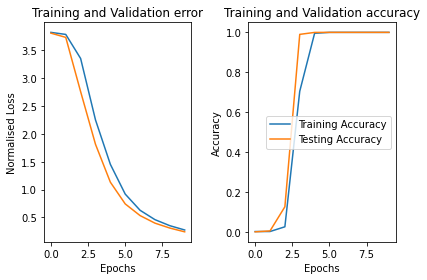

In [64]:
#initialising the lists
train_losses   = []
test_losses    = []
train_accuracy = []
test_accuracy  = []
loss_flag = 0

for epoch in range(1, N_epochs+1):
       print(epoch, '/', N_epochs)

       #train the model
       loss,accuracy = Train_sum(model,L,optimizer,loss_func,loss_flag,N_iter_train = N_iter_train)
       train_losses.append(loss)
       train_accuracy.append(accuracy)
       print('Train loss for Epoch ',epoch,': ',loss,' | ', 'Train accuracy for Epoch ',epoch, ': ',accuracy)

       #test the model
       loss,accuracy = Test_sum(model,L,loss_func,loss_flag,N_iter_test = N_iter_test)
       test_losses.append(loss)
       test_accuracy.append(accuracy)
       print('Test loss for Epoch ',epoch,': ',loss, ' | ', 'Test accuracy for Epoch ',epoch, ': ',accuracy)

#Plotting the Loss and the accuracy curves
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.asfarray(train_losses),label = 'Train Loss') #converting to float array
ax1.plot(np.asfarray(test_losses),label = 'Validation Loss') 
ax1.set(xlabel='Epochs', ylabel='Normalised Loss')
ax1.set_title('Training and Validation error')

ax2.plot(np.asfarray(train_accuracy),label = 'Training Accuracy')
ax2.plot(np.asfarray(test_accuracy),label = 'Testing Accuracy')
ax2.set(xlabel='Epochs', ylabel='Accuracy')
ax2.set_title('Training and Validation accuracy')
ax2.legend()
fig.tight_layout()

In [65]:
def Check_binary_sequence(model,loss_flag,lossfn,N_iter_check):
    
    model.eval()
    
    test_accuracies = []
    
    for L in range(1,21): #iterating through L in the required range
    
        #initializing the total test loss and total correct test predictions to 0
        test_loss    = 0
        test_correct = 0 #correct predictions made
        test_length = N_iter_check
    
        #switching off the gradient for eval
        with torch.no_grad():
            
        
            x,y = binary_sequence_generator(L,batch_size = N_iter_check)
            x = x.to(device)
            y = y.to(device)
        
            pred = model(x.float()) #prediction using the input data
        
            if(loss_flag == 0): #CE Loss
            
                loss = cross_entropy(pred,y.view(pred.size()))
        
            elif(loss_flag == 1): #MSE Loss
            
                loss = lossfn(pred,y.view(pred.size()).float()) #converting to float for MSE loss
            
            #prediction made by LSTM
            threshold = torch.Tensor([0.5])
            pred_y = (pred > threshold).float() * 1
            
            #convert to base 10 equivalent
            pred_y = pred_y.numpy()[:,:,0]
            pred_y = pred_y.dot(2**np.arange(pred_y.shape[1]))

            y_10 = y.numpy()
            y_10 = y_10.dot(2**np.arange(y_10.shape[1]))
    
            #Adding this loss to  testing loss and computing correct predictions
            test_loss    += loss
            test_correct += np.sum(pred_y==y_10) #as subtraction will result in 0 for correct pred
        
            #Computing prediction accuracy 
    
            test_correct /= test_length #prediction accuracy
            
            test_accuracies.append(test_correct)
            
    
    #plotting test accuracies vs L
    
    plt.bar(np.arange(1,21),test_accuracies)
    plt.xlabel('L')
    plt.ylabel('Accuracy')
    plt.ylim(0,1) #as accuracy is between 0 and 1
    plt.grid()
    plt.legend()
    plt.title('Prediction Accuracy vs Length')
    plt.show()
    
    print(f'Prediction Accuracies : {test_accuracies}')

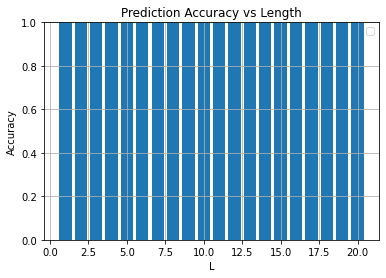

Prediction Accuracies : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [66]:
Check_binary_sequence(model,loss_flag,loss_func,N_iter_check)